In [32]:
import pandas as pd
import numpy as np
import datetime
import xlsxwriter
pd.options.mode.chained_assignment = None  # default='warn'
from pandas.tseries.offsets import DateOffset

import matplotlib.pyplot as plt

In [56]:
xlsx = pd.ExcelFile('Gain Enerji Intern Analyst Case Study Data.xlsx')

wind1_df = pd.read_excel(xlsx, 'Wind_1')
wind2_df = pd.read_excel(xlsx, 'Wind_2')
hydro1_df = pd.read_excel(xlsx, 'Hydro_1')
hydro2_df = pd.read_excel(xlsx, 'Hydro_2')
ptf_smf_df = pd.read_excel(xlsx, 'PTF, SMF')

In [34]:
wind1_df.head()

,Tarih,Saat,Gün Öncesi Üretim Tahmini (MWh),Gün İçi Üretim Tahmini Revizesi (MWh),Gerçekleşen Üretim (MWh)
0,2022-01-01,0,3.2,3.3,5.024
1,2022-01-01,1,3.4,-1.0,3.437
2,2022-01-01,2,3.6,-0.1,0.165
3,2022-01-01,3,2.7,0.9,0.000
4,2022-01-01,4,1.8,1.3,0.156


In [35]:
wind1_df.columns

Index(['Tarih', 'Saat', 'Gün Öncesi Üretim Tahmini (MWh)',
       'Gün İçi Üretim Tahmini Revizesi (MWh)', 'Gerçekleşen Üretim  (MWh)'],
      dtype='object')

In [36]:
ptf_smf_df['Pozitif Dengesizlik Fiyatı'] = ptf_smf_df[['Piyasa Takas Fiyatı (TL/MWh)','Sistem Marjinal Fiyatı (TL/MWh)']].min(axis=1).multiply(0.97)
ptf_smf_df['Negatif Dengesizlik Fiyatı'] = ptf_smf_df[['Piyasa Takas Fiyatı (TL/MWh)','Sistem Marjinal Fiyatı (TL/MWh)']].max(axis=1).multiply(1.03)
ptf_smf_df.head()

,Tarih,Saat,Piyasa Takas Fiyatı (TL/MWh),Sistem Marjinal Fiyatı (TL/MWh),Pozitif Dengesizlik Fiyatı,Negatif Dengesizlik Fiyatı
0,2022-01-01,0,949.98,525.00,509.2500,978.4794
1,2022-01-01,1,800.00,848.01,776.0000,873.4503
2,2022-01-01,2,898.98,990.00,872.0106,1019.7000
3,2022-01-01,3,1047.00,500.00,485.0000,1078.4100
4,2022-01-01,4,799.70,500.00,485.0000,823.6910


In [37]:
PTF = ptf_smf_df['Piyasa Takas Fiyatı (TL/MWh)']
SMF = ptf_smf_df['Sistem Marjinal Fiyatı (TL/MWh)']
PDF = ptf_smf_df['Pozitif Dengesizlik Fiyatı']
NDF = ptf_smf_df['Negatif Dengesizlik Fiyatı']

In [38]:
def YeniSutunlar(df):
    global PTF, PDF, NDF
    df.rename(columns = {'Gün Öncesi Üretim Tahmini (MWh)':'GÖÜT (MWh)', 'Gün İçi Üretim Tahmini Revizesi (MWh)':'GİÜTR (MWh)', 'Gerçekleşen Üretim  (MWh)':'G. Üretim (MWh)'}, inplace = True)
    df['GÖP Fiyatı'] = df['GÖÜT (MWh)'] * PTF
    df['GİP Fiyatı'] = df['GİÜTR (MWh)'] * PTF
    df['Dengesizlik'] = df['G. Üretim (MWh)'] - df['GÖÜT (MWh)'] - df['GİÜTR (MWh)']
    df['Dengesizlik Tutarı'] = 0 
    for i,j in df.iterrows():
        if df.loc[i,'Dengesizlik'] > 0:
            df.loc[i,'Dengesizlik Tutarı'] = df.loc[i,'Dengesizlik'] * PDF[i]
        else:
            df.loc[i, 'Dengesizlik Tutarı'] = df.loc[i, 'Dengesizlik'] * NDF[i]        
    df['Toplam Gelir'] = df['GÖP Fiyatı'] + df['GİP Fiyatı'] + df['Dengesizlik Tutarı']
    df['Dengesizlik Maliyeti'] = abs(df['G. Üretim (MWh)'] * PTF - df['Toplam Gelir']) 
    return df

In [39]:
YeniSutunlar(wind1_df)
YeniSutunlar(wind2_df)
YeniSutunlar(hydro1_df)
YeniSutunlar(hydro2_df)
wind1_df.head()

,Tarih,Saat,GÖÜT (MWh),GİÜTR (MWh),G. Üretim (MWh),GÖP Fiyatı,GİP Fiyatı,Dengesizlik,Dengesizlik Tutarı,Toplam Gelir,Dengesizlik Maliyeti
0,2022-01-01,0,3.2,3.3,5.024,3039.936,3134.934,-1.476,-1444.235594,4730.634406,42.065114
1,2022-01-01,1,3.4,-1.0,3.437,2720.000,-800.000,1.037,804.712000,2724.712000,24.888000
2,2022-01-01,2,3.6,-0.1,0.165,3236.328,-89.898,-3.335,-3400.699500,-254.269500,402.601200
3,2022-01-01,3,2.7,0.9,0.000,2826.900,942.300,-3.600,-3882.276000,-113.076000,113.076000
4,2022-01-01,4,1.8,1.3,0.156,1439.460,1039.610,-2.944,-2424.946304,54.123696,70.629504


In [40]:
def AySutunuEkle(df):
    df['Ay']="Aralık"
    first_column = df.pop('Ay')
    df.insert(0, 'Ay', first_column)
    df[df['Tarih'] < pd.to_datetime('2022-02-01')] = df[df['Tarih'] < pd.to_datetime('2022-02-01')].replace(['Aralık'], 'Ocak')
    df[df['Tarih'] < pd.to_datetime('2022-03-01')] = df[df['Tarih'] < pd.to_datetime('2022-03-01')].replace(['Aralık'], 'Şubat')
    df[df['Tarih'] < pd.to_datetime('2022-04-01')] = df[df['Tarih'] < pd.to_datetime('2022-04-01')].replace(['Aralık'], 'Mart') 
    df[df['Tarih'] < pd.to_datetime('2022-05-01')] = df[df['Tarih'] < pd.to_datetime('2022-05-01')].replace(['Aralık'], 'Nisan')
    df[df['Tarih'] < pd.to_datetime('2022-06-01')] = df[df['Tarih'] < pd.to_datetime('2022-06-01')].replace(['Aralık'], 'Mayıs')
    df[df['Tarih'] < pd.to_datetime('2022-07-01')] = df[df['Tarih'] < pd.to_datetime('2022-07-01')].replace(['Aralık'], 'Haziran')
    df[df['Tarih'] < pd.to_datetime('2022-08-01')] = df[df['Tarih'] < pd.to_datetime('2022-08-01')].replace(['Aralık'], 'Temmuz')
    df[df['Tarih'] < pd.to_datetime('2022-09-01')] = df[df['Tarih'] < pd.to_datetime('2022-09-01')].replace(['Aralık'], 'Ağustos')
    df[df['Tarih'] < pd.to_datetime('2022-10-01')] = df[df['Tarih'] < pd.to_datetime('2022-10-01')].replace(['Aralık'], 'Eylül')
    df[df['Tarih'] < pd.to_datetime('2022-11-01')] = df[df['Tarih'] < pd.to_datetime('2022-11-01')].replace(['Aralık'], 'Ekim')
    df[df['Tarih'] < pd.to_datetime('2022-11-01')] = df[df['Tarih'] < pd.to_datetime('2022-11-01')].replace(['Aralık'], 'Kasım')
    return df

In [41]:
AySutunuEkle(wind1_df)
AySutunuEkle(wind2_df)
AySutunuEkle(hydro1_df)
AySutunuEkle(hydro2_df)
wind1_df

,Ay,Tarih,Saat,GÖÜT (MWh),GİÜTR (MWh),G. Üretim (MWh),GÖP Fiyatı,GİP Fiyatı,Dengesizlik,Dengesizlik Tutarı,Toplam Gelir,Dengesizlik Maliyeti
0,Ocak,2022-01-01,0,3.2,3.3,5.024,3039.936000,3134.934000,-1.476,-1444.235594,4730.634406,42.065114
1,Ocak,2022-01-01,1,3.4,-1.0,3.437,2720.000000,-800.000000,1.037,804.712000,2724.712000,24.888000
2,Ocak,2022-01-01,2,3.6,-0.1,0.165,3236.328000,-89.898000,-3.335,-3400.699500,-254.269500,402.601200
3,Ocak,2022-01-01,3,2.7,0.9,0.000,2826.900000,942.300000,-3.600,-3882.276000,-113.076000,113.076000
4,Ocak,2022-01-01,4,1.8,1.3,0.156,1439.460000,1039.610000,-2.944,-2424.946304,54.123696,70.629504
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,Aralık,2022-12-31,19,4.8,-0.6,7.551,23040.000000,-2880.000000,3.351,15538.154702,35698.154702,546.645298
8756,Aralık,2022-12-31,20,4.1,2.5,8.753,19680.000000,12000.000000,2.153,5930.603911,37610.603911,4403.796089
8757,Aralık,2022-12-31,21,4.3,2.7,9.225,20512.801972,12880.131471,2.225,5933.148069,39326.081512,4681.034347
8758,Aralık,2022-12-31,22,4.0,2.3,11.633,16517.995070,9497.847165,5.333,13608.799356,39624.641591,8413.817571


In [54]:
w1 = wind1_df[['Ay', 'Tarih', 'Saat', 'Dengesizlik Tutarı', 'Toplam Gelir', 'Dengesizlik Maliyeti']]
w2 = wind2_df[['Ay', 'Tarih', 'Saat', 'Dengesizlik Tutarı', 'Toplam Gelir', 'Dengesizlik Maliyeti']]
h1 = hydro1_df[['Ay', 'Tarih', 'Saat', 'Dengesizlik Tutarı', 'Toplam Gelir', 'Dengesizlik Maliyeti']]
h2 = hydro2_df[['Ay', 'Tarih', 'Saat', 'Dengesizlik Tutarı', 'Toplam Gelir', 'Dengesizlik Maliyeti']]
w1.head()

,Ay,Tarih,Saat,Dengesizlik Tutarı,Toplam Gelir,Dengesizlik Maliyeti
0,Ocak,2022-01-01,0,-1444.235594,4730.634406,42.065114
1,Ocak,2022-01-01,1,804.712000,2724.712000,24.888000
2,Ocak,2022-01-01,2,-3400.699500,-254.269500,402.601200
3,Ocak,2022-01-01,3,-3882.276000,-113.076000,113.076000
4,Ocak,2022-01-01,4,-2424.946304,54.123696,70.629504


In [52]:
with pd.ExcelWriter('output.xlsx') as writer:  
    w1.to_excel(writer, sheet_name='Wind_1')
    w2.to_excel(writer, sheet_name='Wind_2')
    h1.to_excel(writer, sheet_name='Hydro_1')
    h2.to_excel(writer, sheet_name='Hydro_2')

In [57]:
"""with pd.ExcelWriter('output.xlsx',
                    mode='a') as writer:  
    w2.to_excel(writer, sheet_name='Wind_2')"""

"with pd.ExcelWriter('output.xlsx',\n                    mode='a') as writer:  \n    w2.to_excel(writer, sheet_name='Wind_2')"

In [13]:
w1['Üretim (MWh)'] = wind1_df['G. Üretim (MWh)']
w2['Üretim (MWh)'] = wind2_df['G. Üretim (MWh)']
h1['Üretim (MWh)'] = hydro1_df['G. Üretim (MWh)']
h2['Üretim (MWh)'] = hydro2_df['G. Üretim (MWh)']
#w1['Toplam Üretim'] = wind1_df.groupby('Ay',sort=False)['G. Üretim (MWh)'].sum()
#w2['Toplam Üretim'] = wind2_df.groupby('Ay',sort=False)['G. Üretim (MWh)'].sum()
#h1['Toplam Üretim'] = hydro1_df.groupby('Ay',sort=False)['G. Üretim (MWh)'].sum()
#h2['Toplam Üretim'] = hydro2_df.groupby('Ay',sort=False)['G. Üretim (MWh)'].sum()
w1.head()

,Ay,Tarih,Saat,Dengesizlik Tutarı,Toplam Gelir,Dengesizlik Maliyeti,Üretim (MWh)
0,Ocak,2022-01-01,0,-1444.235594,4730.634406,42.065114,5.024
1,Ocak,2022-01-01,1,804.712000,2724.712000,24.888000,3.437
2,Ocak,2022-01-01,2,-3400.699500,-254.269500,402.601200,0.165
3,Ocak,2022-01-01,3,-3882.276000,-113.076000,113.076000,0.000
4,Ocak,2022-01-01,4,-2424.946304,54.123696,70.629504,0.156


In [14]:
def BirimSutunlarıEkle(df):
    df = df[['Ay', 'Dengesizlik Tutarı', 'Toplam Gelir', 'Dengesizlik Maliyeti', 'Üretim (MWh)']]
    df = df.groupby('Ay',sort=False)[['Dengesizlik Tutarı', 'Toplam Gelir', 'Dengesizlik Maliyeti', 'Üretim (MWh)']].sum()
    df['Birim Dengesizlik Maliyeti (TL/MWh)'] = df['Dengesizlik Maliyeti'] / df['Üretim (MWh)']
    df['Birim Üretim Geliri (TL/MWh)'] = df['Toplam Gelir'] / df['Üretim (MWh)']
    return df

In [15]:
wind1 = BirimSutunlarıEkle(w1)
wind2 = BirimSutunlarıEkle(w2)
hydro1 = BirimSutunlarıEkle(h1)
hydro2 = BirimSutunlarıEkle(h2)
wind1.head()

,Dengesizlik Tutarı,Toplam Gelir,Dengesizlik Maliyeti,Üretim (MWh),Birim Dengesizlik Maliyeti (TL/MWh),Birim Üretim Geliri (TL/MWh)
Ay,,,,,,
Ocak,-8.445914e+05,1.741882e+07,377013.112269,15416.996,24.454382,1129.845095
Şubat,-8.999709e+05,1.451143e+07,322520.645841,10655.084,30.269179,1361.925712
Mart,-1.853532e+06,2.046696e+07,277840.136314,12515.603,22.199501,1635.315428
Nisan,-3.964162e+05,1.493070e+07,885828.801086,9770.645,90.662264,1528.118339
Mayıs,-9.866603e+04,1.114381e+07,573110.655823,7117.293,80.523684,1565.737659


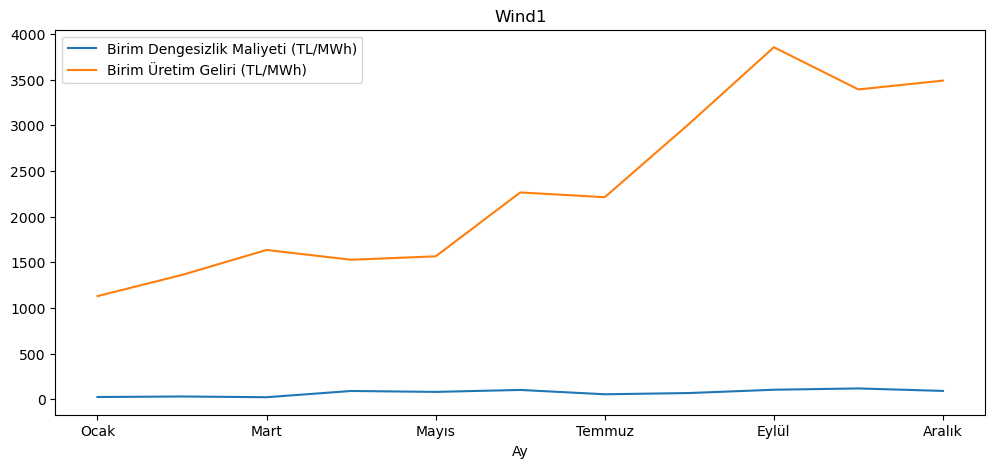

In [63]:
wind1[['Birim Dengesizlik Maliyeti (TL/MWh)', 'Birim Üretim Geliri (TL/MWh)']].plot(title = 'Wind1', figsize=(12, 5))
plt.savefig('Wind1')

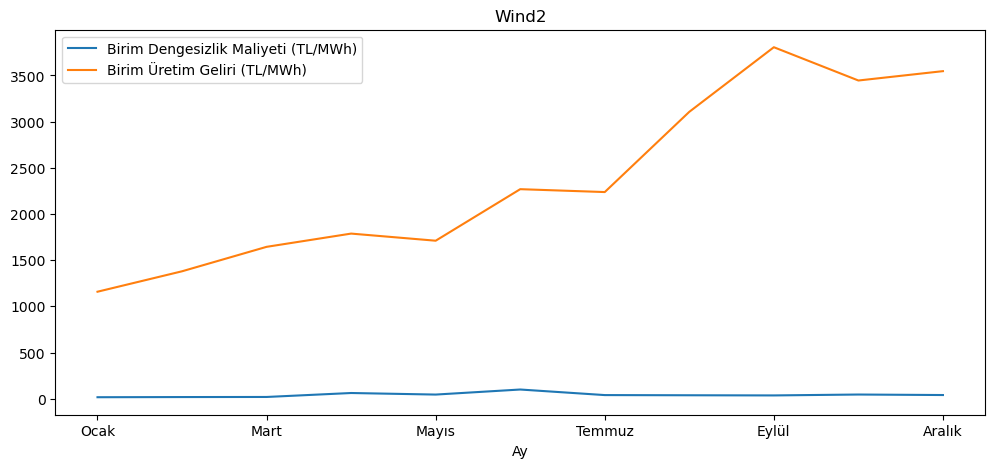

In [64]:
wind2[['Birim Dengesizlik Maliyeti (TL/MWh)', 'Birim Üretim Geliri (TL/MWh)']].plot(title = 'Wind2', figsize=(12, 5))
plt.savefig('Wind2')

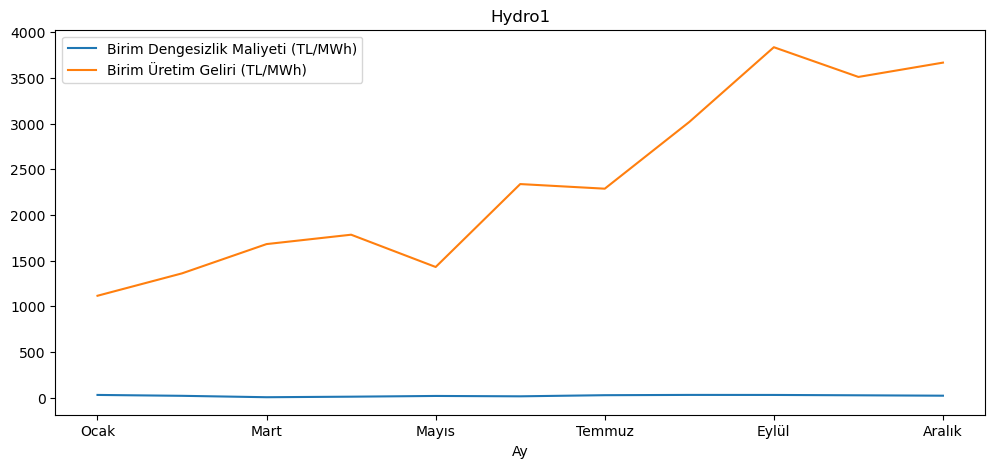

In [65]:
hydro1[['Birim Dengesizlik Maliyeti (TL/MWh)', 'Birim Üretim Geliri (TL/MWh)']].plot(title = 'Hydro1', figsize=(12, 5))
plt.savefig('Hydro1')

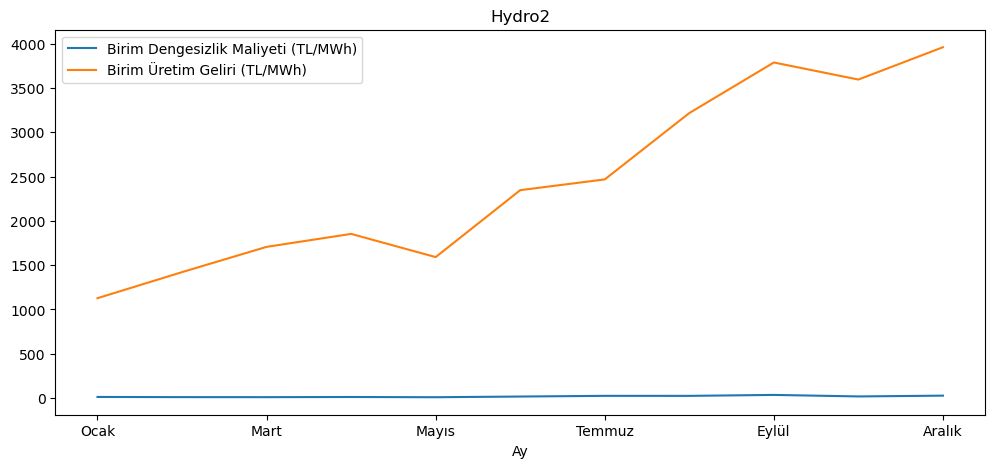

In [66]:
hydro2[['Birim Dengesizlik Maliyeti (TL/MWh)', 'Birim Üretim Geliri (TL/MWh)']].plot(title = 'Hydro2', figsize=(12, 5))
plt.savefig('Hydro2')

In [20]:
bdm = pd.concat([wind1['Birim Dengesizlik Maliyeti (TL/MWh)'], wind2['Birim Dengesizlik Maliyeti (TL/MWh)'], hydro1['Birim Dengesizlik Maliyeti (TL/MWh)'], hydro2['Birim Dengesizlik Maliyeti (TL/MWh)']], axis = 1)
bdm.columns = ['Wind1', 'Wind2', 'Hydro1', 'Hydro2']
bdm.head()

,Wind1,Wind2,Hydro1,Hydro2
Ay,,,,
Ocak,24.454382,16.305791,28.573987,12.416972
Şubat,30.269179,18.049015,18.865152,10.451559
Mart,22.199501,19.075190,3.504338,10.176274
Nisan,90.662264,61.885705,9.405561,11.934874
Mayıs,80.523684,45.033196,17.386651,9.381907


In [21]:
burg = pd.concat([wind1['Birim Üretim Geliri (TL/MWh)'], wind2['Birim Üretim Geliri (TL/MWh)'], hydro1['Birim Üretim Geliri (TL/MWh)'], hydro2['Birim Üretim Geliri (TL/MWh)']], axis = 1)
burg.columns = ['Wind1', 'Wind2', 'Hydro1', 'Hydro2']
burg.head()

,Wind1,Wind2,Hydro1,Hydro2
Ay,,,,
Ocak,1129.845095,1158.616717,1114.349377,1127.138172
Şubat,1361.925712,1379.834298,1359.607441,1421.231778
Mart,1635.315428,1644.542343,1680.069693,1706.361141
Nisan,1528.118339,1788.018358,1782.721643,1852.578792
Mayıs,1565.737659,1710.913326,1429.299838,1590.924207


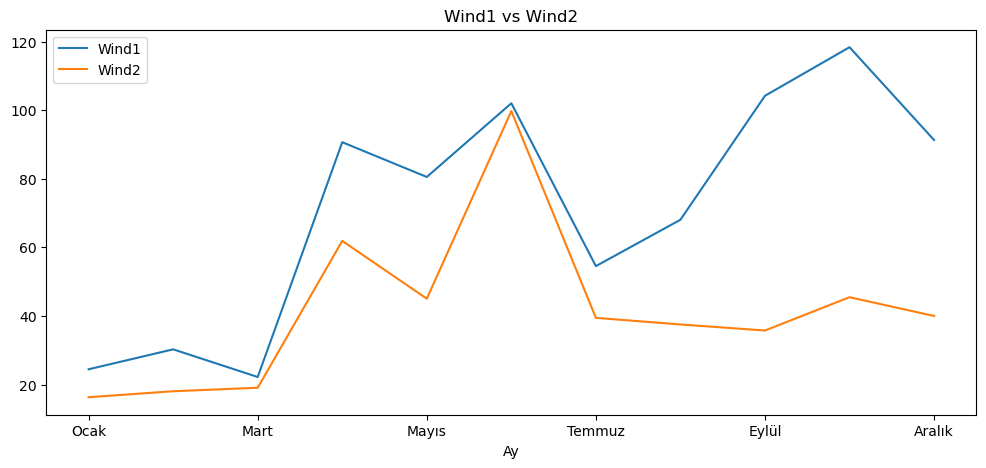

In [67]:
bdm[['Wind1', 'Wind2']].plot(title = 'Wind1 vs Wind2', figsize=(12, 5))
plt.savefig('Wind1 vs Wind2')

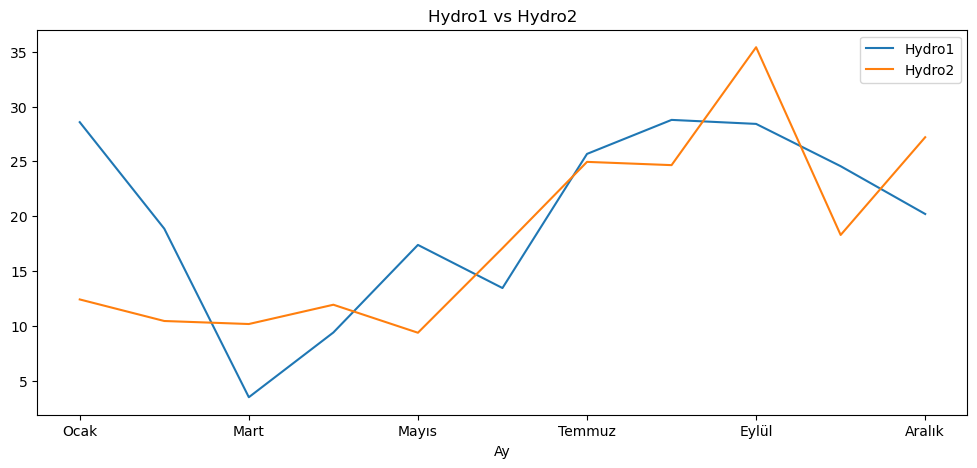

In [69]:
bdm[['Hydro1', 'Hydro2']].plot(title = 'Hydro1 vs Hydro2', figsize=(12, 5))
plt.savefig('Hydro1 vs Hydro2')

In [59]:
bdm[['Hydro1']].mean()

Hydro1    19.894331
dtype: float64

In [60]:
bdm[['Hydro2']].mean()

Hydro2    18.360617
dtype: float64

In [61]:
bdm[['Hydro1']].std()

Hydro1    8.424733
dtype: float64

In [62]:
bdm[['Hydro2']].std()

Hydro2    8.60363
dtype: float64

In [70]:
burg[['Hydro2']].mean()

Hydro2    2460.881293
dtype: float64

In [71]:
burg[['Hydro2']].std()

Hydro2    1021.264163
dtype: float64

In [58]:
yillik = pd.DataFrame([[0, 0, 0, 0], [0, 0, 0, 0]],
                   columns= ['Wind1', 'Wind2', 'Hydro1', 'Hydro2'], 
                 index = ['Birim Dengesizlik Maliyeti (TL/MWh)', 'Birim Üretim Geliri (TL/MWh)'])
yillik

,Wind1,Wind2,Hydro1,Hydro2
Birim Dengesizlik Maliyeti (TL/MWh),0,0,0,0
Birim Üretim Geliri (TL/MWh),0,0,0,0


In [75]:
yillik.loc['Birim Dengesizlik Maliyeti (TL/MWh)','Wind1'] = bdm['Wind1'].sum()
yillik.loc['Birim Dengesizlik Maliyeti (TL/MWh)','Wind2'] = bdm['Wind2'].sum()
yillik.loc['Birim Dengesizlik Maliyeti (TL/MWh)','Hydro1'] = bdm['Hydro1'].sum()
yillik.loc['Birim Dengesizlik Maliyeti (TL/MWh)','Hydro2'] = bdm['Hydro2'].sum()
yillik.loc['Birim Üretim Geliri (TL/MWh)','Wind1'] = burg['Wind1'].sum()
yillik.loc['Birim Üretim Geliri (TL/MWh)','Wind2'] = burg['Wind2'].sum()
yillik.loc['Birim Üretim Geliri (TL/MWh)','Hydro1'] = burg['Hydro1'].sum()
yillik.loc['Birim Üretim Geliri (TL/MWh)','Hydro2'] = burg['Hydro2'].sum()
yillik

,Wind1,Wind2,Hydro1,Hydro2
Birim Dengesizlik Maliyeti (TL/MWh),786.561805,458.268514,218.837636,201.966784
Birim Üretim Geliri (TL/MWh),25458.623263,26093.387906,26019.139271,27069.694219


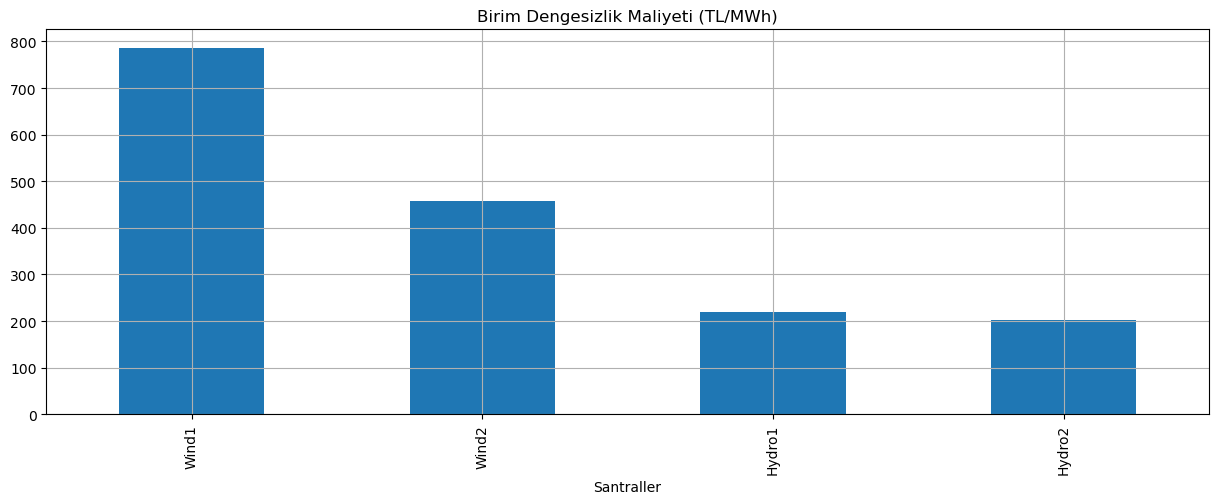

In [77]:
df = yillik.T
df['Birim Dengesizlik Maliyeti (TL/MWh)'].plot(title = 'Birim Dengesizlik Maliyeti (TL/MWh)', xlabel = 'Santraller', grid = True, kind = 'bar', figsize=(15, 5))#hist(figsize=(15, 5))
plt.savefig('Birim Dengesizlik Maliyeti')
plt.show()

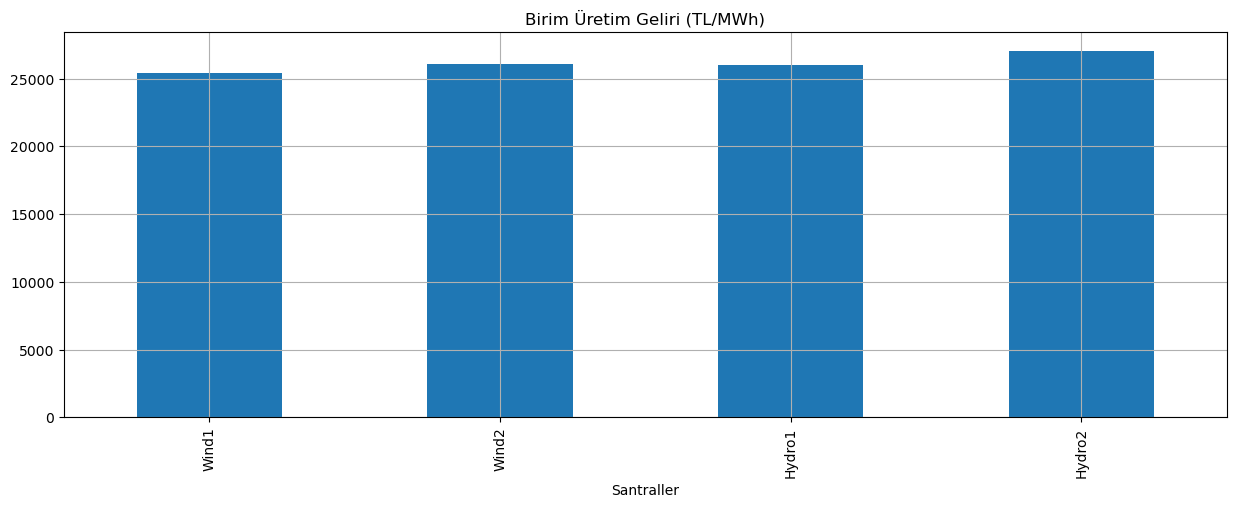

In [78]:
df['Birim Üretim Geliri (TL/MWh)'].plot(title = 'Birim Üretim Geliri (TL/MWh)', xlabel = 'Santraller', grid = True, kind='bar', figsize=(15, 5)) #hist(figsize=(15, 5))
plt.savefig('Birim Üretim Geliri')
plt.show()

Yorumlar
 - Toplam Satış Geliri, Dengesizlik Tutarı ve Dengesizlik Maliyetleri hesaplandı ve excel dosyasına aktarıldı. Excel dosyası mailde ek olarak gönderilecektir.
 - Her bir santralin aylık ve yıllık bazda Birim Üretim Geliri ve Birim Dengesizlik Maliyeti hesaplandı ve bulunan bu değerlerin grafikleri çıkartıldı.
 - Grafiğe bakılarak, rüzgar santrallerinden 2. tip santralin diğer rüzgar santraline göre bariz bir şekilde avantajlı olduğunu düşünüyorum. Çünkü 1. tip rüzgar santralinin "Birim Dengesizlik Maliyeti" yılın her ayında diğer santralden daha yüksek çıkmaktadır. Öte yandan hidroelektrik santrallerinden herhangi birinin diğerine göre bariz bir avantajı olduğu grafiklerden görülemiyor. Ayrıca 2. tip hidroelektrik santralinin ortalama "Birim Dengesizlik Maliyeti" değeri diğer sanrtalden küçük ancak, standart sapma değeri diğer santralden büyük çıkmaktadır. Yani 2. santralin daha az maliyetli ama stabil olmama durumu var.

 - Önerdiğim tesisler: Wind_2 ve Hydro_1:

•	Wind_2 görüldüğü üzere daha az "Birim Dengesizlik Maliyeti" ne sahip olduğu için, daha kârlı bir tesis olacaktır. 

•	Hdyro_1 ve Hydro_2 birbirine yakın ortalama "Birim Dengesizlik Maliyeti’ ne sahip. Hydro_1'in ortalama maliyeti diğerine göre yüksek ama standart sapma değeri düşük. Ancak Birim Üretim Geliri olarak Hydro_2 tesisi daha yüksek değere sahip olduğu için önerilmesi gerektiğini düşünüyorum.